<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/ResNet_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

manualseed = 999 # random seed 고정
random.seed(manualseed) # for numpy
torch.manual_seed(manualseed) # for torch

dtype = torch.float32
device = torch.device('cuda')

Num_Train = 45000
lr = 0.1
num_worker = 4
batch_size = 128
batch_size_test = 100

transform_train = T.Compose([
                       T.RandomCrop(32,padding=4),
                       T.RandomHorizontalFlip(),
                       T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
])
transform_test = T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
])

cifar10_train = dset.CIFAR10(root='./CIFAR10',train=True,
                             download=True,transform=transform_train)
loader_train = DataLoader(cifar10_train,batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(Num_Train)))

cifar10_val = dset.CIFAR10(root='./CIFAR10',train=True,
                           download=True,transform=transform_test)
loader_val = DataLoader(cifar10_val,batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(Num_Train,50000)))

cifar10_test = dset.CIFAR10(root='./CIFAR10',train=False,
                           download=True,transform=transform_test)
loader_test = DataLoader(cifar10_test, batch_size=batch_size_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Make ResNet Model for CIFAR-10

In [5]:
class downsample_pad(nn.Module):
  def __init__(self,in_channels,out_channels,stride):
    super().__init__()
    self.maxpool = nn.MaxPool2d(1,stride)
    self.pad = nn.ConstantPad3d((0,0,0,0,0,out_channels-in_channels),0)

  def forward(self,x):
    out = self.maxpool(x)
    out = self.pad(out)
    return out

class ResBlock(nn.Module):
  def __init__(self,in_channels,out_channels,stride):
    super().__init__()
    self.stride = stride
    self.conv1 = nn.Conv2d(in_channels,out_channels,3,padding=1,bias=False,stride=stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(True)
    self.conv2 = nn.Conv2d(out_channels,out_channels,3,padding=1,bias=False,stride=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsampad = downsample_pad(in_channels,out_channels,stride)
    
  def forward(self,x):
    if self.stride == 2:
      shortcut = self.downsampad(x)
    else:
      shortcut = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += shortcut
    out = self.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self,n,num_classes=10):
    super().__init__()
    self.n = n
    self.conv1 = nn.Conv2d(3,16,3,padding=1,bias=False) # N*16*32*32
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU(True)

    self.layers_2n_32 = self.make_layers(16,16,1)# N*16*32*32
    self.layers_2n_16 = self.make_layers(16,32,2)# N*32*16*16
    self.layers_2n_8 = self.make_layers(32,64,2)# N*64*8*8

    self.gloavg_pool = nn.AvgPool2d(8)# N*64*1*1
    self.flatten = nn.Flatten()
    self.fc_out = nn.Linear(64*1*1,num_classes)# N*10

    for m in self.modules(): # weight initialization
      classname = m.__class__.__name__
      if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
      elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias,0)
        
  def make_layers(self,in_channels,out_channels,stride):
    layers = []
    layers += [ResBlock(in_channels,out_channels,stride=stride)]
    for _ in range(self.n-1):
      layers += [ResBlock(out_channels,out_channels,stride=1)]
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.layers_2n_32(x)
    x = self.layers_2n_16(x)
    x = self.layers_2n_8(x)

    x = self.gloavg_pool(x)
    x = self.flatten(x)
    x = self.fc_out(x)
    return x

# Make Plain Model for CIFAR-10

In [6]:
class Block(nn.Module):
  def __init__(self,in_channels,out_channels,stride):
    super().__init__()
    self.stride = stride
    self.conv1 = nn.Conv2d(in_channels,out_channels,3,padding=1,bias=False,stride=stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(True)
    self.conv2 = nn.Conv2d(out_channels,out_channels,3,padding=1,bias=False,stride=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    
  def forward(self,x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    return out

class PlainNet(nn.Module):
  def __init__(self,n,num_classes=10):
    super().__init__()
    self.n = n
    self.conv1 = nn.Conv2d(3,16,3,padding=1,bias=False) # N*16*32*32
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU(True)

    self.layers_2n_32 = self.make_layers(16,16,1)# N*16*32*32
    self.layers_2n_16 = self.make_layers(16,32,2)# N*32*16*16
    self.layers_2n_8 = self.make_layers(32,64,2)# N*64*8*8

    self.gloavg_pool = nn.AvgPool2d(8)# N*64*1*1
    self.flatten = nn.Flatten()
    self.fc_out = nn.Linear(64*1*1,num_classes)# N*10

    for m in self.modules(): # weight initialization
      classname = m.__class__.__name__
      if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
      elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias,0)
        
  def make_layers(self,in_channels,out_channels,stride):
    layers = []
    layers += [Block(in_channels,out_channels,stride=stride)]
    for _ in range(self.n-1):
      layers += [Block(out_channels,out_channels,stride=1)]
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.layers_2n_32(x)
    x = self.layers_2n_16(x)
    x = self.layers_2n_8(x)

    x = self.gloavg_pool(x)
    x = self.flatten(x)
    x = self.fc_out(x)
    return x

# Start Training

In [7]:
net = PlainNet(3).to(device) # can choose resnet or plainnet and n=3,5,7,9...
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('The number of parameters of model is', num_params)
#print(net)

optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=1e-4)
schedule = [32000,48000]
lr_sche = optim.lr_scheduler.MultiStepLR(optimizer, milestones=schedule, gamma=0.1)

TrainError_log = []
TestError_log = []
total_iter = 0
end_iter = 64000
epochs = 0
print_every = 4000

def train(model, total_iter):
  model.train()
  num_correct = 0
  num_samples = 0
  for t,(x,y) in enumerate(loader_train):
    total_iter += 1
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    loss = F.cross_entropy(scores,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_sche.step()
  return total_iter
  
def check_acc(model,loader,log, test):
  model.eval()
  num_correct = 0
  num_samples = 0

  for (x,y) in loader:
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    _, predicts = torch.max(scores,dim=1)
    num_correct += torch.sum(predicts == y)
    num_samples += predicts.size(0)

  acc = float(num_correct) / num_samples
  error = 100*(1-acc)
  log.append(error)
  if test:
    print('(TestError) correct : %d / %d, error (%.2f)' % (num_correct,num_samples,error))
  else:
    print('(TrainError) correct : %d / %d, error (%.2f)' % (num_correct,num_samples,error))

The number of parameters of model is 269722


In [30]:
while True:
  epochs += 1
  total_iter = train(net,total_iter)
  check_acc(net, loader_train, TrainError_log, test=False)
  check_acc(net, loader_test, TestError_log, test=True)
  print('iter : %d / %d , epochs : %d' % (total_iter, end_iter, epochs))

  if total_iter >= end_iter:
    dataframe1 = pd.DataFrame(TrainError_log)
    dataframe1.to_csv('drive/MyDrive/Colab_Projects/ResNet/plainnet_20_trainerr.csv',header=False,index=False)
    dataframe2 = pd.DataFrame(TestError_log)
    dataframe2.to_csv('drive/MyDrive/Colab_Projects/ResNet/plainnet_20_testerr.csv',header=False,index=False)
    print('training finished')
    break

(TrainError) correct : 17835 / 45000, error (60.37)
(TestError) correct : 4142 / 10000, error (58.58)
iter : 352 / 64000 , epochs : 1
(TrainError) correct : 22921 / 45000, error (49.06)
(TestError) correct : 5226 / 10000, error (47.74)
iter : 704 / 64000 , epochs : 2
(TrainError) correct : 27689 / 45000, error (38.47)
(TestError) correct : 6164 / 10000, error (38.36)
iter : 1056 / 64000 , epochs : 3


KeyboardInterrupt: ignored

**Result exemple(PlainNet(3))**

(TrainError) correct : 17648 / 45000, error (60.78)

(TestError) correct : 3954 / 10000, error (60.46)

iter : 352 / 64000 , epochs : 1

(TrainError) correct : 21323 / 45000, error (52.62)

(TestError) correct : 4836 / 10000, error (51.64)

iter : 704 / 64000 , epochs : 2

....

(TrainError) correct : 44766 / 45000, error (0.52)

(TestError) correct : 8999 / 10000, error (10.01)

iter : 64064 / 64000 , epochs : 182

training finished

# **Final Results**

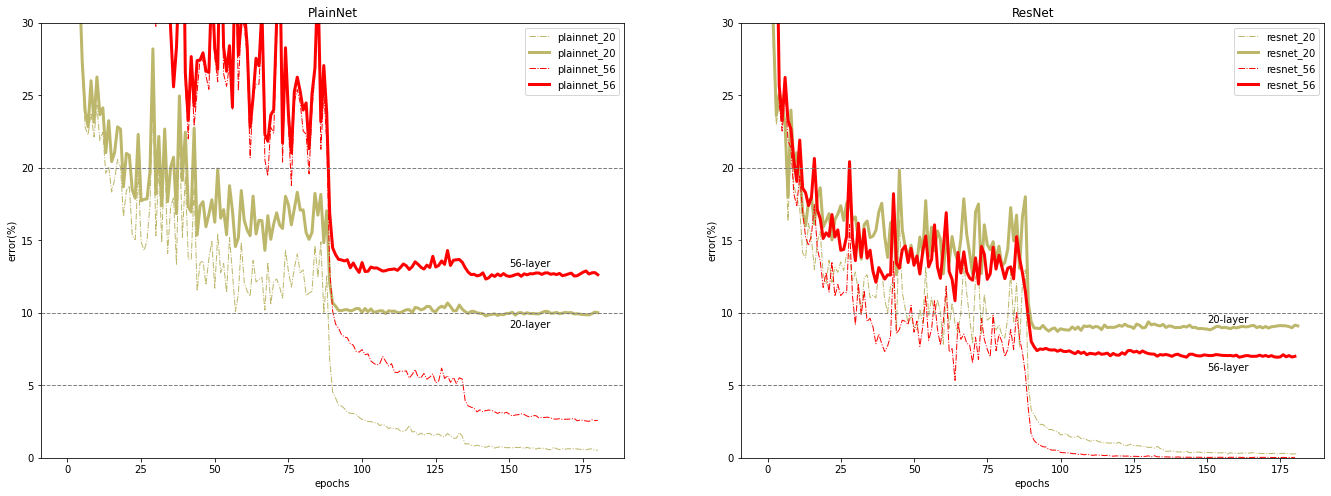

In [35]:
resnet_20_train_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/resnet_20_trainerr.csv')
resnet_20_test_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/resnet_20_testerr.csv')
resnet_56_train_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/resnet_56_trainerr.csv')
resnet_56_test_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/resnet_56_testerr.csv')

plainnet_20_train_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/plainnet_20_trainerr.csv')
plainnet_20_test_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/plainnet_20_testerr.csv')
plainnet_56_train_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/plainnet_56_trainerr.csv')
plainnet_56_test_err = pd.read_csv('drive/MyDrive/Colab_Projects/ResNet/plainnet_56_testerr.csv')

plt.figure(figsize=(23,8))

plt.subplot(1,2,1)
plt.title('PlainNet')
plt.ylim(0,30)
plt.plot(plainnet_20_train_err,label='plainnet_20',linestyle='-.',linewidth=1,color='darkkhaki')
plt.plot(plainnet_20_test_err,label='plainnet_20',linewidth=3,color='darkkhaki')
plt.plot(plainnet_56_train_err,label='plainnet_56',linestyle='-.',linewidth=1,color='red')
plt.plot(plainnet_56_test_err,label='plainnet_56',linewidth=3, color='red')
plt.text(150,13.2,'56-layer')
plt.text(150,9,'20-layer')
plt.axhline(20,0,1,color='gray',linestyle='--',linewidth='1')
plt.axhline(10,0,1,color='gray',linestyle='--',linewidth='1')
plt.axhline(5,0,1,color='gray',linestyle='--',linewidth='1')
plt.xlabel('epochs')
plt.ylabel('error(%)')
plt.legend()

plt.subplot(1,2,2)
plt.title('ResNet')
plt.ylim(0,30)
plt.plot(resnet_20_train_err,label='resnet_20',linestyle='-.',linewidth=1,color='darkkhaki')
plt.plot(resnet_20_test_err,label='resnet_20',linewidth=3,color='darkkhaki')
plt.plot(resnet_56_train_err,label='resnet_56',linestyle='-.',linewidth=1, color='red')
plt.plot(resnet_56_test_err,label='resnet_56',linewidth=3, color='red')
plt.text(150,6,'56-layer')
plt.text(150,9.3,'20-layer')
plt.axhline(20,0,1,color='gray',linestyle='--',linewidth='1')
plt.axhline(10,0,1,color='gray',linestyle='--',linewidth='1')
plt.axhline(5,0,1,color='gray',linestyle='--',linewidth='1')
plt.xlabel('epochs')
plt.ylabel('error(%)')
plt.legend()

plt.show()